# Bitcoin Prediction using Random Forest

In [1]:
# Define Quandl Helper Function to download and cache bitcoin dataset from Quandl
import json
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

    #CODE CHANGES -BALAJI
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df


# Pull Kraken BTC exchange historical pricing data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

btc_usd_price_kraken.head()

Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [2]:
# Chart the BTC close pricing data
#% matplotlib inline
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Close'])
py.iplot([btc_trace])


There are a few notable down-spikes, particularly in late 2014 and early 2016. These spikes are specific to the Kraken dataset, and I obviously don't want them to be reflected in my overall pricing analysis.

The nature of Bitcoin exchanges is that the pricing is determined by supply and demand, hence no single exchange contains a true "master price" of Bitcoin. To solve this issue, along with that of down-spikes, I pulled data from three more major Bitcoin changes to calculate an aggregate Bitcoin price index.

In [3]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Cached BCHARTS/COINBASEUSD at BCHARTS-COINBASEUSD.pkl
Cached BCHARTS/BITSTAMPUSD at BCHARTS-BITSTAMPUSD.pkl
Cached BCHARTS/ITBITUSD at BCHARTS-ITBITUSD.pkl


In [4]:
# Merge All Of The Pricing Data Into A Single Dataframe
def merge_dfs_on_column(dataframes, labels, col):
    # Merge a single column of each dataframe into a new combined dataframe
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

# Merge the BTC price dataseries' into a single dataframe on their "Close Price" column
btc_usd_datasets_close = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Close')
btc_usd_datasets_open = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Open')
btc_usd_datasets_high = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'High')
btc_usd_datasets_low = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Low')

btc_usd_datasets_close.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2018-04-17,7890.87,7892.10,7891.30,7893.1
2018-04-18,8172.84,8152.05,8168.11,8170.0
2018-04-19,8271.31,8274.00,8275.60,8275.7
2018-04-20,8861.00,8866.27,8859.65,8875.0
2018-04-21,8802.85,8810.01,8803.14,8829.1


In [5]:
# Visualize The Pricing Datasets

# Helper function to provide a single-line command to compare each column in the dataframe
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    #Generate a scatter plot of the entire dataframe
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)
    
# Plot all of the BTC exchange closing prices
df_scatter(btc_usd_datasets_close, 'Bitcoin Closing Price (USD) By Exchange')

In [6]:
# Remove "0" values
btc_usd_datasets_close.replace(0, np.nan, inplace=True)
btc_usd_datasets_open.replace(0, np.nan, inplace=True)
btc_usd_datasets_high.replace(0, np.nan, inplace=True)
btc_usd_datasets_low.replace(0, np.nan, inplace=True)

# Plot the cleaned dataframe
df_scatter(btc_usd_datasets_close, 'Bitcoin Closing Price (USD) By Exchange')

In [8]:
# Calculate the average BTC closing price as a new column
btc_usd_datasets_close['avg_btc_close_price_usd'] = btc_usd_datasets_close.mean(axis=1)
btc_usd_datasets_open['avg_btc_open_price_usd'] = btc_usd_datasets_open.mean(axis=1)
btc_usd_datasets_high['avg_btc_high_price_usd'] = btc_usd_datasets_high.mean(axis=1)
btc_usd_datasets_low['avg_btc_low_price_usd'] = btc_usd_datasets_low.mean(axis=1)

# Plot the average BTC closing price
btc_trace = go.Scatter(x=btc_usd_datasets_close.index, y=btc_usd_datasets_close['avg_btc_close_price_usd'])
py.iplot([btc_trace])

In [9]:
btc_usd_datasets_close_final = btc_usd_datasets_close['avg_btc_close_price_usd'].copy()
btc_usd_datasets_open_final = btc_usd_datasets_open['avg_btc_open_price_usd'].copy()
btc_usd_datasets_high_final = btc_usd_datasets_high['avg_btc_high_price_usd'].copy()
btc_usd_datasets_low_final = btc_usd_datasets_low['avg_btc_low_price_usd'].copy()

btc_usd_datasets_close_final = btc_usd_datasets_close_final.reset_index()
btc_usd_datasets_open_final = btc_usd_datasets_open_final.reset_index()
btc_usd_datasets_high_final = btc_usd_datasets_high_final.reset_index()
btc_usd_datasets_low_final = btc_usd_datasets_low_final.reset_index()

btc_usd_datasets_open_final.columns = ['Date','Average Open Price (USD)']
btc_usd_datasets_high_final.columns = ['Date','Average High Price (USD)']
btc_usd_datasets_low_final.columns = ['Date','Average Low Price (USD)']
btc_usd_datasets_close_final.columns = ['Date','Average Close Price (USD)']

btc_usd_datasets_close_final.head()

,Date,Average Close Price (USD)
0,2011-09-13,5.97
1,2011-09-14,5.53
2,2011-09-15,5.13
3,2011-09-16,4.85
4,2011-09-17,4.87


In [10]:
btc_usd_datasets_final_1 = pd.merge(btc_usd_datasets_open_final, btc_usd_datasets_high_final, on='Date')
btc_usd_datasets_final_2 = pd.merge(btc_usd_datasets_low_final, btc_usd_datasets_close_final, on='Date')                                  
btc_usd_datasets_final = pd.merge(btc_usd_datasets_final_1, btc_usd_datasets_final_2, on='Date') 
btc_usd_datasets_final.to_csv('BTC_USD.csv', index=False)
btc_usd_datasets_final.head()                                   

,Date,Average Open Price (USD),Average High Price (USD),Average Low Price (USD),Average Close Price (USD)
0,2011-09-13,5.80,6.00,5.65,5.97
1,2011-09-14,5.58,5.72,5.52,5.53
2,2011-09-15,5.12,5.24,5.00,5.13
3,2011-09-16,4.82,4.87,4.80,4.85
4,2011-09-17,4.87,4.87,4.87,4.87


In [13]:
bitcoin = pd.read_csv('BTC_USD.csv', parse_dates=['Date'], index_col='Date')
bitcoin.tail()

,Average Open Price (USD),Average High Price (USD),Average Low Price (USD),Average Close Price (USD)
Date,,,,
2018-04-17,8052.6375,8165.1075,7813.6575,7891.8425
2018-04-18,7891.8200,8254.1275,7872.5800,8165.7500
2018-04-19,8165.9025,8299.4750,8092.3975,8274.1525
2018-04-20,8272.9250,8936.0425,8220.3050,8865.4800
2018-04-21,8866.7000,9043.5325,8616.2625,8811.2750


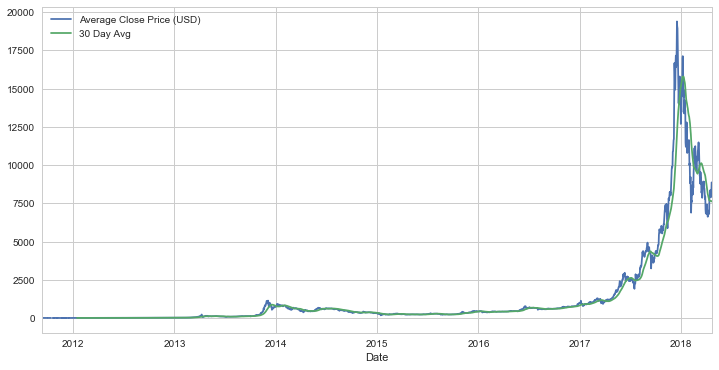

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.set_style('whitegrid')
bitcoin['Average Close Price (USD)'].plot(figsize=(12,6),label='Average Close Price (USD)')
bitcoin['Average Close Price (USD)'].rolling(window=30).mean().plot(label='30 Day Avg')# Plotting the 
#rolling 30 day average against the Close Price
plt.legend()

In [18]:
#I will be adding a feature to improve the model.This feature is provided by Tafarel Yan in his Kernel

bitcoin['ohlc_average'] = (bitcoin['Average Open Price (USD)'] + bitcoin['Average High Price (USD)'] + bitcoin['Average Low Price (USD)'] + bitcoin['Average Close Price (USD)']) / 4

In [20]:
bitcoin.head()

,Average Open Price (USD),Average High Price (USD),Average Low Price (USD),Average Close Price (USD),ohlc_average
Date,,,,,
2011-09-13,5.80,6.00,5.65,5.97,5.8550
2011-09-14,5.58,5.72,5.52,5.53,5.5875
2011-09-15,5.12,5.24,5.00,5.13,5.1225
2011-09-16,4.82,4.87,4.80,4.85,4.8350
2011-09-17,4.87,4.87,4.87,4.87,4.8700


In [21]:
bitcoin['Price_After_Month']=bitcoin['Average Close Price (USD)'].shift(-30)

In [23]:
bitcoin.tail()

,Average Open Price (USD),Average High Price (USD),Average Low Price (USD),Average Close Price (USD),ohlc_average,Price_After_Month
Date,,,,,,
2018-04-17,8052.6375,8165.1075,7813.6575,7891.8425,7980.811250,NaN
2018-04-18,7891.8200,8254.1275,7872.5800,8165.7500,8046.069375,NaN
2018-04-19,8165.9025,8299.4750,8092.3975,8274.1525,8207.981875,NaN
2018-04-20,8272.9250,8936.0425,8220.3050,8865.4800,8573.688125,NaN
2018-04-21,8866.7000,9043.5325,8616.2625,8811.2750,8834.442500,NaN


In [26]:
#Preprocessing
from sklearn import preprocessing
bitcoin.dropna(inplace=True)
X=bitcoin.drop('Price_After_Month',axis=1)
X=preprocessing.scale(X)#We need to scale our values to input them in our model
y=bitcoin['Price_After_Month']

In [28]:
from sklearn import cross_validation
X_train,X_test,y_train,y_test=cross_validation.train_test_split(X,y,test_size=0.3,random_state=101)

C:\Users\Balaji\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [29]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 91.6349 %


In [30]:
preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])

The prediction is: 15.256450000000003 But the real value is: 16.52


In [31]:
#Apply our model and get our prediction
X_30=X[-30:]#We'll take the last 30 elements to make our predictions on them
forecast=reg.predict(X_30)

In [32]:
#creating a new column which contains the predictions! 
#Proceed at your own risk!  
from datetime import datetime, timedelta
last_date=bitcoin.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
bitcoin=bitcoin.append(df1)
bitcoin.tail()

,Average Close Price (USD),Average High Price (USD),Average Low Price (USD),Average Open Price (USD),Forecast,Price_After_Month,ohlc_average
2018-04-17,NaN,NaN,NaN,NaN,10463.594375,NaN,NaN
2018-04-18,NaN,NaN,NaN,NaN,8527.398462,NaN,NaN
2018-04-19,NaN,NaN,NaN,NaN,8522.391475,NaN,NaN
2018-04-20,NaN,NaN,NaN,NaN,9153.989762,NaN,NaN
2018-04-21,NaN,NaN,NaN,NaN,8895.659900,NaN,NaN


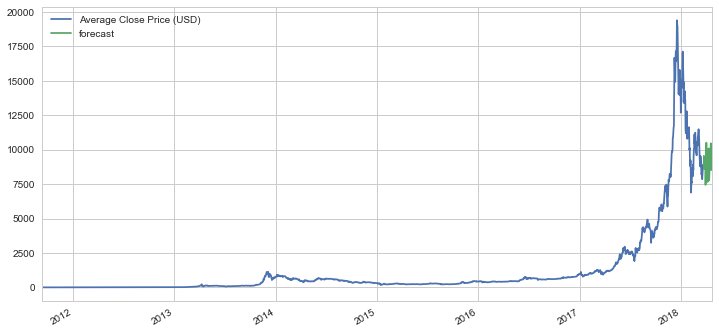

In [34]:
#Now we'll plot our forecast! 
bitcoin['Average Close Price (USD)'].plot(figsize=(12,6),label='Average Close Price (USD)')
bitcoin['Forecast'].plot(label='forecast')
plt.legend()

In [35]:
bitcoin.tail()

,Average Close Price (USD),Average High Price (USD),Average Low Price (USD),Average Open Price (USD),Forecast,Price_After_Month,ohlc_average
2018-04-17,NaN,NaN,NaN,NaN,10463.594375,NaN,NaN
2018-04-18,NaN,NaN,NaN,NaN,8527.398462,NaN,NaN
2018-04-19,NaN,NaN,NaN,NaN,8522.391475,NaN,NaN
2018-04-20,NaN,NaN,NaN,NaN,9153.989762,NaN,NaN
2018-04-21,NaN,NaN,NaN,NaN,8895.659900,NaN,NaN
